In [1]:
# Setup stuff

import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
import HARK.ConsumptionSaving.ConsumerParameters as param
import copy
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from HARK.ConsumptionSaving.ConsPortfolioModel import PortfolioSolution
print(PortfolioSolution.__init__.__doc__)

We implement three different ways to allow portfolio choice.
           The agent can choose
              * any portfolio share ('continuous choice')
              * only a specified set of portfolio shares ('discrete choice')
                * With probability 1 (agent always gets to choose)
                * With probability 0 < p < 1 (stochastic chance to choose)

           We allow two choices for the description of the
           distribution of the stochastic variable:
           1. A generic discrete probability distribution
              * Nodes and their probabilities are specified
           2. A true lognormal distribution
              * The mean return and the standard deviation are specified

           In the discrete portfolio shares case, the user also must
           input a function that *draws* from the distribution in drawRiskyFunc

           Other assumptions:
              * distributions are time constant
              * probability of being allowed to reopti

We implement three different ways to allow portfolio choice.
           The agent can choose 
              * any portfolio share ('continuous choice')
              * only a specified set of portfolio shares ('discrete choice')
                * With probability 1 (agent always gets to choose)
                * With probability 0 < p < 1 (stochastic chance to choose)
        
           We allow two choices for the description of the 
           distribution of the stochastic variable:
           1. A generic discrete probability distribution
              * Nodes and their probabilities are specified
           2. A true lognormal distribution
              * The mean return and the standard deviation are specified
        
           In the discrete portfolio shares case, the user also must
           input a function that *draws* from the distribution in drawRiskyFunc

           Other assumptions: 
              * distributions are time constant
              * probability of being allowed to reoptimize is time constant
                 * If p < 1, you must specify the PortfolioSet discretely
        

In [2]:
# Set up the model and its parameters
Avg = 1.08 # equity premium 
Std = 0.15 # standard deviation of rate-of-return shocks

RiskyDstnFunc = cpm.RiskyDstnFactory(RiskyAvg=Avg, RiskyStd=Std) # Generates nodes for integration
RiskyDrawFunc = cpm.LogNormalRiskyDstnDraw(RiskyAvg=Avg, RiskyStd=Std) # Generates draws from the "true" distribution

init_portfolio = copy.copy(param.init_lifecycle)
init_portfolio['approxRiskyDstn'] = RiskyDstnFunc
init_portfolio['drawRiskyFunc']   = RiskyDrawFunc
init_portfolio['RiskyCount']      = 10
init_portfolio['RiskyShareCount'] = 30
init_portfolio['Rfree']           = 1.0
init_portfolio['CRRA']            = 6.0
init_portfolio['aXtraMax']        = 100
init_portfolio['aXtraCount']      = 50
init_portfolio['BoroCnstArt']     = 0.0 # important for theoretical reasons
# init_portfolio['vFuncBool'] = True # We do not need value function for purposes here
pcct = cpm.PortfolioConsumerType(**init_portfolio)

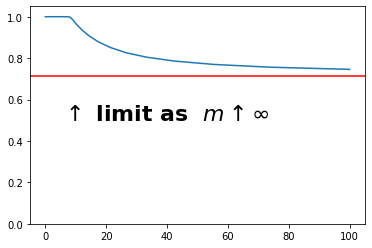

In [3]:
# Solve the model under the given parameters

pcct.solve()
eevalgrid = np.linspace(0,100,100)
plt.plot(eevalgrid, pcct.solution[6].RiskyShareFunc[0][0](eevalgrid))
plt.axhline(pcct.RiskyShareLimitFunc(RiskyDstnFunc(init_portfolio['RiskyCount'])), c='r')
plt.ylim(0,1.05)
plt.text(5,0.5,r'$\uparrow $ limit as  $m \uparrow \infty$',fontsize = 22,fontweight='bold')
plt.show()

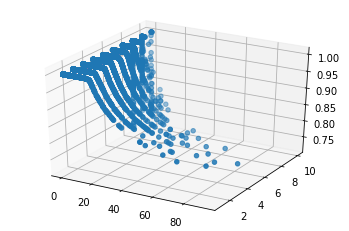

In [4]:
# Simulate 10 years of behavior according to the model

pcct.track_vars = ['aNrmNow', 't_age', 'RiskyShareNow']
pcct.T_sim = 10
pcct.initializeSim()
pcct.simulate()
pcct.RiskyShareNow_hist

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcct.aNrmNow_hist, pcct.t_age_hist, pcct.RiskyShareNow_hist)
plt.show()

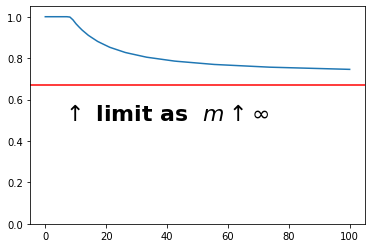

In [5]:
# Solve the specialized / simple version for which there is a good approximation
# This is the version for which Campbell and Viceira provide an approximate formula
# assuming log normally distributed shocks

init_lognormportfolio = copy.deepcopy(init_portfolio) # Use same parameter values
init_lognormportfolio['RiskyAvg'] = Avg
init_lognormportfolio['RiskyStd'] = Std

lnpcct = cpm.LogNormalPortfolioConsumerType(**init_lognormportfolio)

lnpcct.solve()

eevalgrid = np.linspace(0,100,100)
plt.plot(eevalgrid, lnpcct.solution[6].RiskyShareFunc[0][0](eevalgrid))
plt.axhline(lnpcct.RiskyShareLimitFunc(RiskyDstnFunc(init_portfolio['RiskyCount'])), c='r')
plt.ylim(0,1.05)
plt.text(5,0.5,r'$\uparrow $ limit as  $m \uparrow \infty$',fontsize = 22,fontweight='bold')
plt.show()

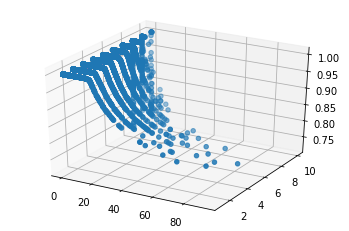

In [6]:
# Again simulate a few periods 
lnpcct.track_vars = ['aNrmNow', 't_age', 'RiskyShareNow']
lnpcct.T_sim = 10
lnpcct.initializeSim()
lnpcct.simulate()
lnpcct.RiskyShareNow_hist

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lnpcct.aNrmNow_hist, lnpcct.t_age_hist, lnpcct.RiskyShareNow_hist)
plt.show()

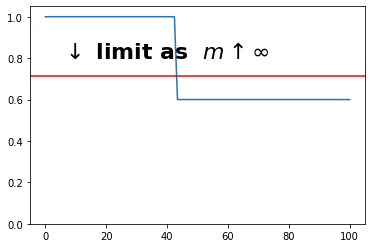

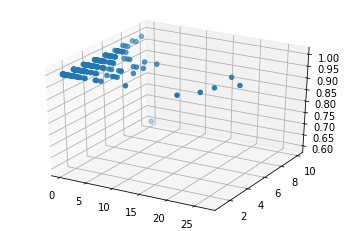

In [7]:
# Version where only discrete values of portfolio share of risky assets are allowed
init_portfolio_prb = copy.deepcopy(init_portfolio)

init_portfolio_prb['AdjustPrb'] = 1.0
init_portfolio_prb['PortfolioDomain'] = cpm.DiscreteDomain([0.0, 0.5, 0.6, 1.0])
pcct_prb = cpm.PortfolioConsumerType(**init_portfolio_prb)
pcct_prb.solve()

eevalgrid = np.linspace(0,100,100)
plt.plot(eevalgrid, pcct_prb.solution[6].RiskyShareFunc[0][0](eevalgrid))
plt.axhline(pcct_prb.RiskyShareLimitFunc(RiskyDstnFunc(init_portfolio['RiskyCount'])), c='r')
plt.ylim(0,1.05)
plt.text(5,0.8,r'$\downarrow $ limit as  $m \uparrow \infty$',fontsize = 22,fontweight='bold')
plt.show()

pcct_prb.track_vars = ['aNrmNow', 't_age', 'RiskyShareNow', 'CantAdjust']
pcct_prb.T_sim = 10
pcct_prb.AgentCount = 30
pcct_prb.initializeSim()
pcct_prb.simulate()
pcct_prb.RiskyShareNow_hist

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcct_prb.aNrmNow_hist, pcct_prb.t_age_hist, pcct_prb.RiskyShareNow_hist)
plt.show()

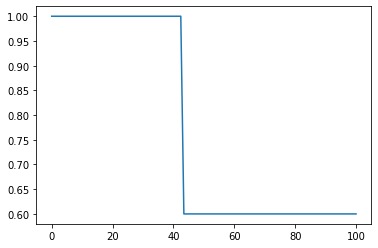

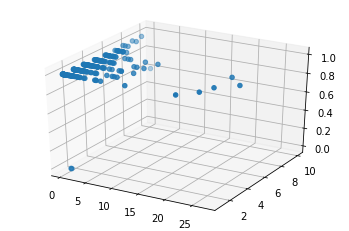

In [8]:
# Version where you can choose your portfolio share only with some 0 < p < 1

init_portfolio_prb = copy.deepcopy(init_portfolio)

init_portfolio_prb['AdjustPrb'] = 0.8
init_portfolio_prb['PortfolioDomain'] = cpm.DiscreteDomain([0.0, 0.6, 1.0])
pcct_prb = cpm.PortfolioConsumerType(**init_portfolio_prb)

pcct_prb.solve()

eevalgrid = np.linspace(0,100,100)
plt.plot(eevalgrid, pcct_prb.solution[6].RiskyShareFunc[0][0](eevalgrid))
plt.show()

pcct_prb.track_vars = ['aNrmNow', 't_age', 'RiskyShareNow', 'CantAdjust']
pcct_prb.T_sim = 10
pcct_prb.AgentCount = 30
pcct_prb.initializeSim()
pcct_prb.simulate()
pcct_prb.RiskyShareNow_hist

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcct_prb.aNrmNow_hist, pcct_prb.t_age_hist, pcct_prb.RiskyShareNow_hist)
plt.show()